In [2]:
# Importing the packages
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
%matplotlib inline 

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from keras.models import Sequential 
from keras.layers import LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0,1))

In [3]:
# Reading the csv file 
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


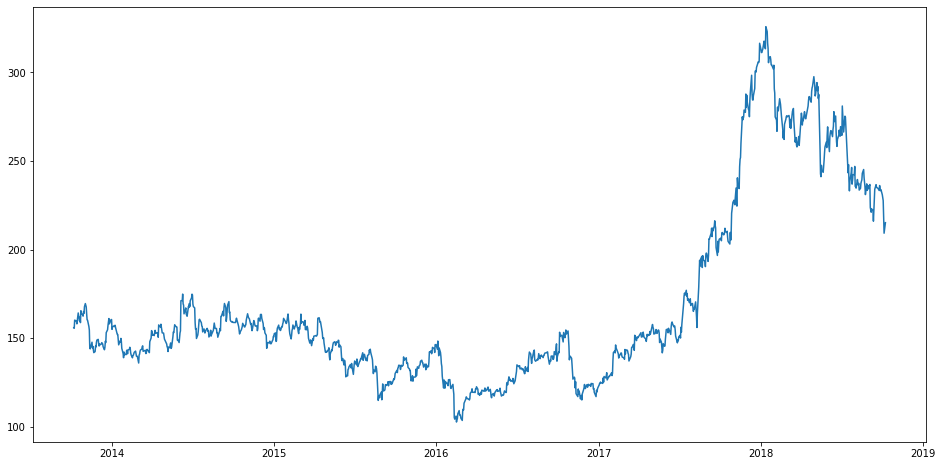

In [4]:
#Getting the closing prices from the dataframe
df["Date"] = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize = (16,8))
plt.plot(df["Close"], label = 'Close Price Trend')

In [33]:
#Cleaning the data/Sorting the dataset on date time 
data = df.sort_index(ascending = True, axis = 0)
new_dataset = pd.DataFrame(index = range(0, len(df)), columns = ['Date', 'Close'])
for i in range (0, len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]

In [34]:
#Normalizing the dataset 
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis = 1, inplace = True)

final_dataset = new_dataset.values 

rough_data = final_dataset[0:987, :]
valid_data = final_dataset[987:, :]



scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(final_dataset)

x_rough_data, y_rough_data = [], [] 

for i in range(60, len(rough_data)):
    x_rough_data.append(scaled_data[i - 60:i, 0])
    y_rough_data.append(scaled_data[i, 0])

x_rough_data, y_rough_data = np.array(x_rough_data), np.array(y_rough_data)

x_rough_data = np.reshape(x_rough_data, (x_rough_data.shape[0], x_rough_data.shape[1], 1))


In [35]:
lstm_method = Sequential()
lstm_method.add(LSTM(units = 50, return_sequences = True, input_shape = (x_rough_data.shape[1], 1)))
lstm_method.add(LSTM(units = 50))
lstm_method.add(Dense(1))

input_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
input_data = input_data.reshape(-1, 1)
input_data = scaler.transform(input_data)

lstm_method.compile(loss = 'mean_squared_error', optimizer = 'adam')
lstm_method.fit(x_rough_data, y_rough_data, epochs = 1, batch_size = 1, verbose = 2)


927/927 - 19s - loss: 0.0013


In [39]:
X_test = []
for i in range(60, input_data.shape[0]):
    X_test.append(input_data[i - 60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_closing_price = lstm_method.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)


In [41]:
lstm_method.save("saved_method.h5")

<ipython-input-42-cce888af32da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


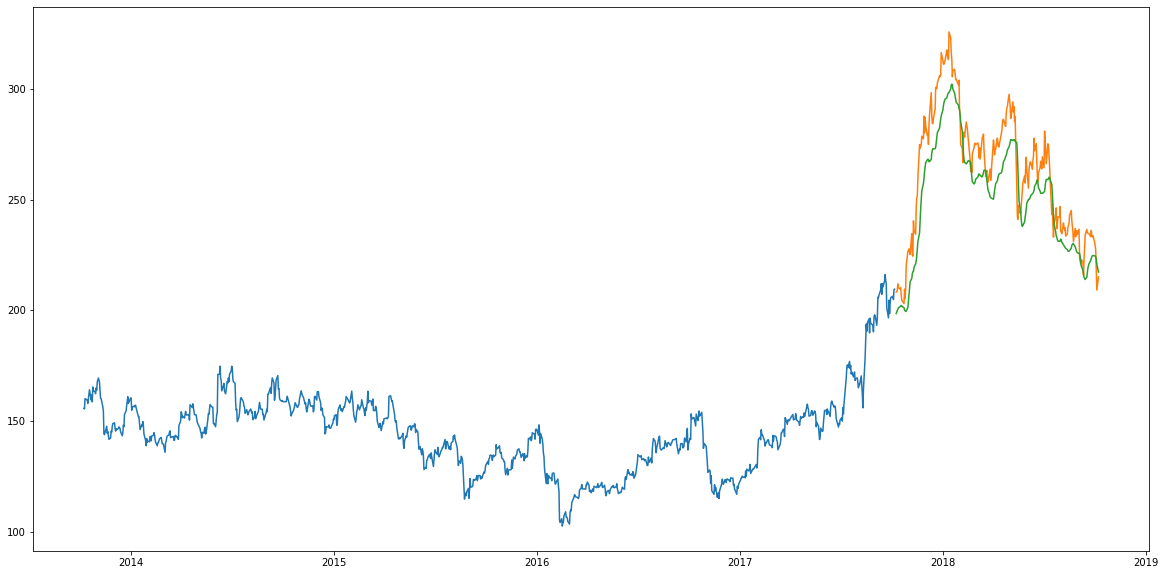

In [42]:
rough_data = new_dataset[:987]
valid_data = new_dataset[987:]
valid_data['Predictions'] = predicted_closing_price
plt.plot(rough_data["Close"])
plt.plot(valid_data[['Close', "Predictions"]])